In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import collections
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import ShuffleSplit

2024-02-25 18:37:47.714126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 18:37:47.714248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 18:37:47.859934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Input paths
input_path = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
test_images_dir = os.path.join(input_path, 'stage_2_test/')
train_images_dir = os.path.join(input_path, 'stage_2_train/')

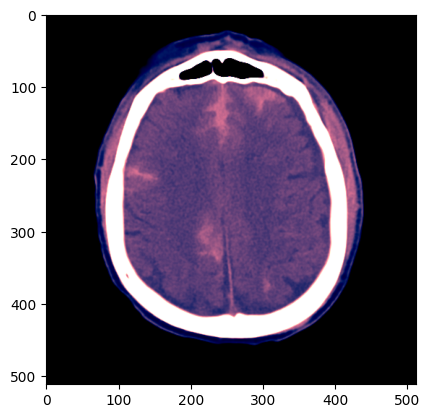

In [3]:
def correct_dcm(dcm):
    """
    Correct DICOM pixel values.
    """
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x >= px_mode] -= px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    """
    Apply specified window level and width to the DICOM image.
    """
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    """
    Apply Brain, Subdural, and Soft tissue windowing to the DICOM image.
    """
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1, 2, 0)

    return bsb_img

# Load a sample DICOM image for visualization
dicom = pydicom.dcmread(os.path.join(train_images_dir, 'ID_5c8b5d701.dcm'))

# Display the DICOM image after applying Brain, Subdural, and Soft tissue windowing
plt.imshow(bsb_window(dicom), cmap=plt.cm.bone)
plt.show()

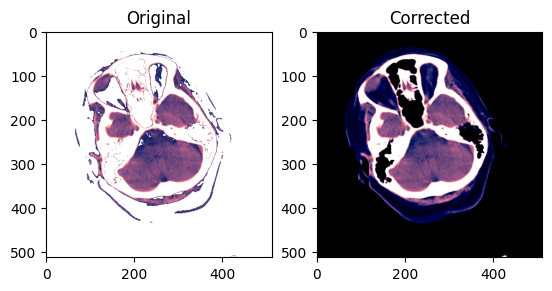

In [4]:
def window_with_correction(dcm, window_center, window_width):
    """
    Apply windowing to DICOM image with correction for specific conditions.
    """
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_without_correction(dcm, window_center, window_width):
    """
    Apply windowing to DICOM image without correction.
    """
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_testing(img, window):
    """
    Apply Brain, Subdural, and Soft tissue windowing to the DICOM image.
    """
    brain_img = window(img, 40, 80)
    subdural_img = window(img, 80, 200)
    soft_img = window(img, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1, 2, 0)

    return bsb_img

# Load an example DICOM image for visualization
dicom = pydicom.dcmread(os.path.join(train_images_dir, "ID_036db39b7.dcm"))

# Plot original and corrected images side by side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(window_testing(dicom, window_without_correction), cmap=plt.cm.bone)
ax[0].set_title("Original")
ax[1].imshow(window_testing(dicom, window_with_correction), cmap=plt.cm.bone)
ax[1].set_title("Corrected")
plt.show()


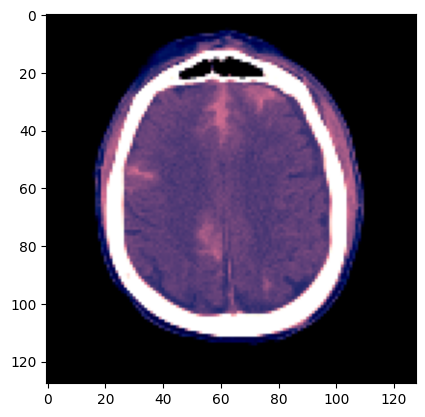

In [5]:
def _read(path, desired_size):
    """
    Read DICOM file, apply windowing, and resize the image.
    This function will be used in DataGenerator.
    """
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except Exception as e:
        print(f"An error occurred: {e}")
        img = np.zeros(desired_size)
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

# Another sanity check 
plt.imshow(
    _read(train_images_dir + 'ID_5c8b5d701' + '.dcm', (128, 128)), cmap=plt.cm.bone
)
plt.show()

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), 
                 img_dir=train_images_dir, *args, **kwargs):
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X

    def on_epoch_end(self):
        if self.labels is not None:
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None:
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(os.path.join(self.img_dir, ID + ".dcm"), self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else:
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(os.path.join(self.img_dir, ID + ".dcm"), self.img_size)
            
            return X

In [7]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    eps = K.epsilon()
    y_pred = K.clip(y_pred, eps, 1.0 - eps)
    out = -(y_true * K.log(y_pred) * class_weights + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    return K.mean(out, axis=-1)

def _normalized_weighted_average(arr, weights=None):
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)

def weighted_loss(y_true, y_pred):
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    eps = K.epsilon()
    y_pred = K.clip(y_pred, eps, 1.0 - eps)
    loss = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    loss_samples = _normalized_weighted_average(loss, class_weights)
    return K.mean(loss_samples)

def weighted_log_loss_metric(trues, preds):
    class_weights = [2., 1., 1., 1., 1., 1.]
    epsilon = 1e-7
    preds = np.clip(preds, epsilon, 1 - epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)
    return -loss_samples.mean()

In [8]:
class PredictionCheckpoint(keras.callbacks.Callback):
    def __init__(self, test_df, valid_df, test_images_dir=test_images_dir, valid_images_dir=train_images_dir, 
                 batch_size=32, input_size=(224, 224, 3)):
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size

    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []

    def on_epoch_end(self, batch, logs={}):
        self.test_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir), 
                verbose=2)[:len(self.test_df)]
        )
        # Uncomment this part if you want to compute validation predictions and losses
        # self.valid_predictions.append(
        #     self.model.predict_generator(
        #         DataGenerator(self.valid_df.index, None, self.batch_size, self.input_size, self.valid_images_dir), 
        #         verbose=2)[:len(self.valid_df)]
        # )
        # print("validation loss: %.4f" % weighted_log_loss_metric(self.valid_df.values, np.average(self.valid_predictions, axis=0, weights=[2**i for i in range(len(self.valid_predictions))])))

class MyDeepModel:
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, 
                 decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        engine = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                             backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
        out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)
        self.model = keras.models.Model(inputs=engine.input, outputs=out)
        self.model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[weighted_loss])

    def fit_and_predict(self, train_df, valid_df, test_df):
        pred_history = PredictionCheckpoint(test_df, valid_df, input_size=self.input_dims)
        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        self.model.fit_generator(
            DataGenerator(train_df.index, train_df, self.batch_size, self.input_dims, train_images_dir),
            epochs=self.num_epochs,
            verbose=self.verbose,
            use_multiprocessing=True,
            workers=4,
            callbacks=[pred_history, scheduler]
        )
        return pred_history

    def save(self, path):
        self.model.save_weights(path)

    def load(self, path):
        self.model.load_weights(path)

In [9]:
def read_testset(filename=input_path + "stage_2_sample_submission.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_trainset(filename=input_path + "stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346, 56347, 56348, 56349,
        56350, 56351, 1171830, 1171831,
        1171832, 1171833, 1171834, 1171835,
        3705312, 3705313, 3705314, 3705315,
        3705316, 3705317, 3842478, 3842479,
        3842480, 3842481, 3842482, 3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

test_df = read_testset()
df = read_trainset()

In [10]:
df.head(3)

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0

In [11]:
test_df.head(3)

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000000e27   0.5      0.5              0.5              0.5          0.5   
ID_000009146   0.5      0.5              0.5              0.5          0.5   
ID_00007b8cb   0.5      0.5              0.5              0.5          0.5   

                       
Diagnosis    subdural  
Image                  
ID_000000e27      0.5  
ID_000009146      0.5  
ID_00007b8cb      0.5

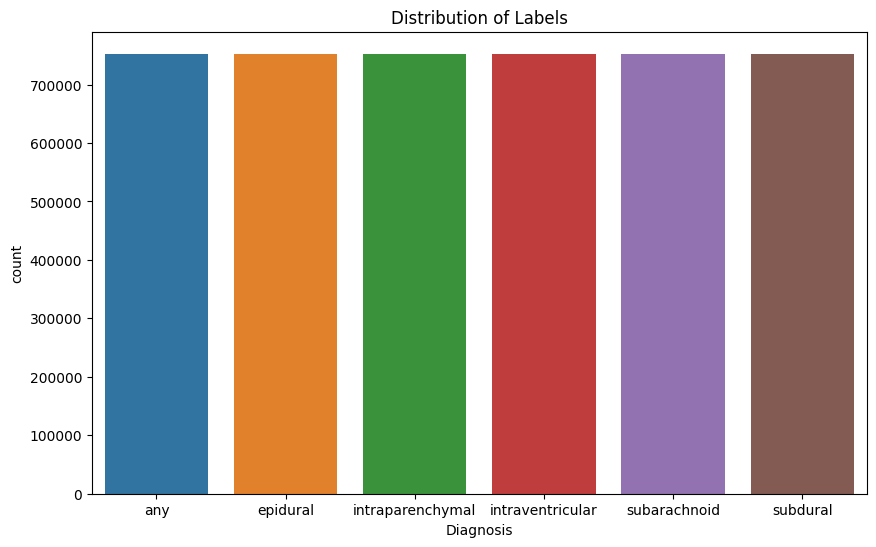

In [12]:
import seaborn as sns

# Plotting count distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(df.Label)
plt.title('Distribution of Labels')
plt.show()

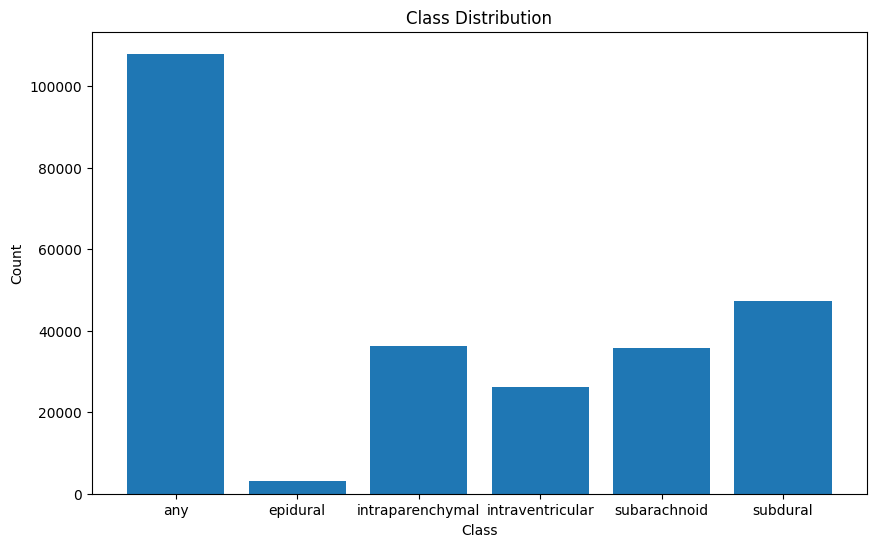

In [13]:
# 1. Histogram of Class Distribution
class_distribution = df['Label'].sum(axis=0)
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.index, class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

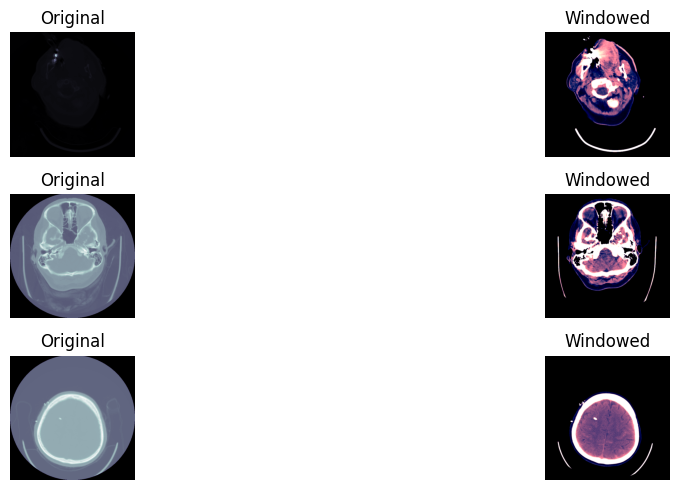

In [14]:
def window_image(dcm, window_center, window_width, intercept, slope):
    """
    Apply specified window level and width to the DICOM image.
    """
    img = dcm.pixel_array * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    
    return img

def bsb_window(dcm):
    """
    Apply Brain, Subdural, and Soft tissue windowing to the DICOM image.
    """
    brain_img = window_image(dcm, 40, 80, dcm.RescaleIntercept, dcm.RescaleSlope)
    subdural_img = window_image(dcm, 80, 200, dcm.RescaleIntercept, dcm.RescaleSlope)
    soft_img = window_image(dcm, 40, 380, dcm.RescaleIntercept, dcm.RescaleSlope)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1, 2, 0)
    
    return bsb_img

# Now, let's plot the sample DICOM images with their windowed versions
sample_ids = df.sample(n=3).index
plt.figure(figsize=(15, 5))
for i, img_id in enumerate(sample_ids):
    plt.subplot(3, 2, 2*i+1)
    dcm = pydicom.dcmread(os.path.join(train_images_dir, f'{img_id}.dcm'))
    plt.imshow(dcm.pixel_array, cmap=plt.cm.bone)
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(3, 2, 2*i+2)
    plt.imshow(bsb_window(dcm), cmap=plt.cm.bone)
    plt.title('Windowed')
    plt.axis('off')
plt.tight_layout()
plt.show()